
# Imports and layer setup, grid and inital concentration definition
## hier noch Einheiten 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the layers using a dictionary
# WICHTIG: d/nx Verhältnis muss identisch sein
def define_layers():
    return [
        {'D': 2.743570484315141e-10, 'd': 0.2, 'nx': 100, 'K_value': 1, 'C_init': 1000 , 'density': 1},   # Layer 1 
        {'D': 1e-2, 'd': 1.85, 'nx': 925, 'K_value': None, 'C_init': 0.0, 'density': 0.9}   # Last Layer
    ]



def initialize_grid(layers):
    x = []
    
    for i, layer in enumerate(layers):
        d = layer['d']
        nx = layer['nx']
        
        if i == 0:
            x1 = np.linspace(0, d, nx, endpoint=True)
        else:
            # Ensure that the last point of the previous layer and first point of current layer align
            x1 = np.linspace(np.sum([l['d'] for l in layers[:i]]), 
                             np.sum([l['d'] for l in layers[:i+1]]), 
                             nx, 
                             endpoint=True)  # Use endpoint=True to align the grids at the interface
        x.append(x1)

    # Concatenate the grid points
    x = np.concatenate(x)

    return x


# Function to initialize the concentration profile
def initialize_concentration(layers, x):
    Nx = sum([layer['nx'] for layer in layers])  # Total number of grid points
    C_init = np.zeros(Nx)  # Initial concentrations

    # Fill the concentration based on the 'C_init' value of each layer
    start_idx = 0
    for layer in layers:
        end_idx = start_idx + layer['nx']
        C_init[start_idx:end_idx] = layer['C_init']
        start_idx = end_idx

    return C_init.copy(), C_init

# Initializing matrices 

In [3]:
# Initialize the matrices A and B, with partitioning between layers
def initialize_matrices(layers, dt):
    # Extract layer parameters
    D = [layer['D'] for layer in layers]
    nx = [layer['nx'] for layer in layers]
    d = [layer['d'] for layer in layers]
    K_values = [layer['K_value'] for layer in layers if layer['K_value'] is not None]
    
    # Total number of grid points
    Nx = sum(nx)
    
    # Spatial step for each layer
    dx = [(d[i] / (nx[i] - 1)) for i in range(len(d))]

    # Initialize A and B matrices
    A = np.zeros((Nx, Nx))
    B = np.zeros((Nx, Nx))

    # Define alpha values for each layer
    alphas = [D[i] * dt / (2 * dx[i]**2) for i in range(len(D))]

    # Fill in the inner matrix points for each layer (excluding boundary points)
    start_idx = 0
    for i in range(len(D)):
        alpha = alphas[i]
        end_idx = start_idx + nx[i]

        # Fill in the interior points for the current layer
        for j in range(start_idx + 1, end_idx - 1):
            A[j, j] = 1 + 2 * alpha
            A[j, j-1] = -alpha
            A[j, j+1] = -alpha

            B[j, j] = 1 - 2 * alpha
            B[j, j-1] = alpha
            B[j, j+1] = alpha
        
        start_idx = end_idx

    # Handle the boundary and partitioning conditions
    # Ghost-point boundary conditions at the edges (left and right boundaries)
    A[0, 0] = 1 + 2 * alphas[0]  # Left boundary
    A[-1, -1] = 1 + 2 * alphas[-1]  # Right boundary
    A[0, 1] = -2 * alphas[0]
    A[-1, -2] = -2 * alphas[-1]

    B[0, 0] = 1 - 2 * alphas[0]
    B[-1, -1] = 1 - 2 * alphas[-1]
    B[0, 1] = 2 * alphas[0]
    B[-1, -2] = 2 * alphas[-1]

    # Partitioning conditions and flux-continuity at the interfaces between layers
    for i in range(1, len(D)):
        if K_values and i <= len(K_values):
            idx = sum(nx[:i])  # Interface index between layer i-1 and i
            
            D1 = D[i-1]
            D2 = D[i]
            alpha1 = alphas[i-1]
            alpha2 = alphas[i]
            K = K_values[i-1]


            # Interface condition for layer i-1 (left side of the interface)
            A[idx-1, idx-2] = -alpha1
            A[idx-1, idx-1] = (1 + 2 * alpha1 - D1 / (D1 + D2) * alpha1 + D2 / (D1 + D2) * alpha1)
            A[idx-1, idx] = -2 * alpha1 * (D2 / (D1 + D2)) * K

            B[idx-1, idx-2] = alpha1
            B[idx-1, idx-1] = (1 - 2 * alpha1 + D1 / (D1 + D2) * alpha1 - D2 / (D1 + D2) * alpha1)
            B[idx-1, idx] = 2 * alpha1 * (D2 / (D1 + D2)) * K

            # Interface condition for layer i (right side of the interface)
            A[idx, idx-1] = -2 * alpha2 * (D1 / (D1 + D2)) / K
            A[idx, idx] = (1 + 2 * alpha2 - D2 / (D1 + D2) * alpha2 + D1 / (D1 + D2) * alpha2)
            A[idx, idx+1] = -alpha2

            B[idx, idx-1] = 2 * alpha2 * (D1 / (D1 + D2)) / K
            B[idx, idx] = (1 - 2 * alpha2 + D2 / (D1 + D2) * alpha2 - D1 / (D1 + D2) * alpha2)
            B[idx, idx+1] = alpha2
            

    return A, B

# Run Simulation

In [4]:
# Time-stepping and simulation loop with partitioning check
def run_simulation(layers, T, dt, steps_to_plot):
    
    # Function to check partitioning at the interfaces between layers
    def check_partitioning(layers, C, C_values):
        K_values = [layer['K_value'] for layer in layers if layer['K_value'] is not None]
        nx = [layer['nx'] for layer in layers]
        
        partitioning_checks = [[] for _ in range(len(K_values))]  # One list for each interface
        
        # Loop over saved time steps
        for i in range(len(C_values)):
            # Loop over all interfaces between layers
            for interface_idx in range(len(K_values)):
                idx_left = sum(nx[:interface_idx+1]) - 1  # Last index of the left layer
                idx_right = idx_left + 1  # First index of the right layer
                
                # Safeguard to avoid division by zero or NaN
                if C_values[i][idx_right] == 0 or np.isnan(C_values[i][idx_right]):
                    K_calc = 1  # Assign infinity if division by zero happens
                else:
                    K_calc = C_values[i][idx_left] / C_values[i][idx_right]
                
                # Store the calculated ratio
                partitioning_checks[interface_idx].append(K_calc / K_values[interface_idx])
        
        return partitioning_checks
    
    # Function to solve the system at each time step
    def solve_timestep(A, B, C):
        # Compute the right-hand side (b = B @ C)
        b = B @ C
        
        # Solve the linear system A * C_new = b
        C_new = np.linalg.solve(A, b)
        
        return C_new
    
    x = initialize_grid(layers)
    C, C_init = initialize_concentration(layers, x)
    A, B = initialize_matrices(layers, dt)
    
    Nt = int(T / dt)
    total_masses = []
    C_values = []
    
    
    # Time integration loop
    for n in range(Nt):
        # Solve for the new concentration profile
        C_new = solve_timestep(A, B, C)
        
        # Update concentration
        C[:] = C_new
        
        
        # Save concentration profiles and mass at specific time steps
        total_mass = np.trapz(C, x)
        total_masses.append(total_mass)
        C_values.append(C.copy())
    
    # Partitioning checks at the interfaces
    partitioning_checks = check_partitioning(layers, C, C_values)
    
    return C_values, total_masses, x, partitioning_checks

# Utility functions

## Plotting functions

### Results

In [27]:
def plot_results(C_values, Nt, dt, x, C_init, layers, log_scale=False, steps_to_plot=10):
    
    def get_time_label(t, dt):
        time_in_seconds = t * dt
        
        # Define time label based on the magnitude of time
        if time_in_seconds < 3600:  # Less than 1 hour
            time_label = f't={time_in_seconds:.0f} s'
        elif time_in_seconds < 3600 * 24:  # Less than 24 hours
            time_label = f't={time_in_seconds / 3600:.1f} h'
        else:  # More than 24 hours
            time_label = f't={time_in_seconds / (3600 * 24):.1f} d'
        
        return time_label
    
    # Determine the time steps to plot (logarithmic or linear)
    if log_scale:
        # Logarithmic time steps: better resolution at early stages
        time_steps_to_plot = np.unique(np.logspace(0, np.log10(Nt-1), num=steps_to_plot, dtype=int))
        # Ensure t=0 is included
        time_steps_to_plot = np.insert(time_steps_to_plot, 0, 0)
    else:
        # Linear time steps
        time_steps_to_plot = np.linspace(0, Nt-1, num=steps_to_plot, dtype=int)

    # Define layer properties for colors, diffusion, and partitioning
    diffusion_coeffs = [layer['D'] for layer in layers]
    K_values = [layer['K_value'] for layer in layers if layer['K_value'] is not None]
    nx = [layer['nx'] for layer in layers]
    d = [layer['d'] for layer in layers]

    # Plot concentration profiles
    plt.figure(figsize=(10, 6))

    # Lists to store lines for time legend and patches for layer legend
    time_lines = []
    
    # Plot the concentration profiles at the determined time steps
    for i, t in enumerate(time_steps_to_plot):
        time_label = get_time_label(t, dt)
        
        if t == 0:
            line, = plt.plot(x, C_init, label=f'{time_label}' , color='k')
        else:
            C_plot = C_values[t]
            line, = plt.plot(x, C_plot, label=f'{time_label}')
        
        time_lines.append(line)

    # Define the RGB colors
    colors = [(241/255, 109/255, 29/255), (153/255, 230/255, 223/255)]  # Convert to values between 0 and 1
    labels = ["LDPE", "fl. Kontaktphase"]

    # Add vertical lines and layer colors for each layer
    layer_patches = []  # To store the patches for the layer legend
    start_idx = 0
    for i, layer in enumerate(layers):
        end_idx = start_idx + layer['nx']
        # Get the x range for the current layer
        x_layer = x[start_idx:end_idx]
        
        # Shade each layer with a different color
        # patch = plt.fill_between(x_layer, 0, max(C_init), color=f"C{i}", alpha=0.15, label=f"Layer {i+1}")
        patch = plt.fill_between(x_layer, 0, max(C_init), color=colors[i % len(colors)], alpha=0.3, label=labels[i % len(labels)])
        layer_patches.append(patch)

        # # Display the diffusion coefficient in the middle of each layer
        # x_mid = np.mean(x_layer) 
        # plt.text(x_mid, max(C_init) + 50, f"D = {layer['D']:.2e} $cm^2/s$", fontsize=12, ha='left', rotation = 60)

        # # Add vertical lines at the interfaces between layers (except the last layer)
        # if i < len(layers) - 1:
        #     plt.text(x[end_idx-1], max(C_init) + 50, f"K = {K_values[i]:.2f}", fontsize=12, ha='left', rotation = 60)

        # Update start index for the next layer
        start_idx = end_idx

    plt.xlim(x[0], x[-1])
    plt.ylim(0, max(C_init)+5)   # Increase the upper limit to give more space for text annotations
    plt.xlabel('Position x $[cm]$', fontsize = 14)
    plt.ylabel('Konzentration $[mg/kg]$', fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    # First legend for time information (Concentration over time)
    first_legend = plt.legend(handles=time_lines, loc='upper right', bbox_to_anchor=(1.25, 1.02), fontsize = 14)
    plt.gca().add_artist(first_legend)  # Add the first legend manually
    
    # Second legend for layers, positioned separately from the time legend
    plt.legend(handles=layer_patches, loc='upper right', bbox_to_anchor=(1.33, 0.16), fontsize = 14)
    # Speichern der Ergebnisse 
    plt.savefig("/Users/tomhartmann/Documents/00_UNI/01_MASTER/STUDIENARBEIT/000_Vektorgrafiken/Modellvergleich/vergleich-Konzentrationsverlauf.pdf", bbox_inches='tight')

    plt.show()


### Mass conservation

In [6]:
def plot_mass_conservation(total_masses, total_mass_init, T, Nt, plot_interval):
    # Calculate the mass difference from the initial total mass
    rel_deviation = ((np.array(total_masses) - total_mass_init) / total_mass_init) * 100
    
    # Create an array of time values corresponding to the simulation steps
    time_values = np.linspace(0, T, Nt)
    # Plot every 'plot_interval' time step
    plt.figure(figsize=(10, 6))
    plt.plot(time_values[::plot_interval] / 3600, rel_deviation[::plot_interval], 
             label=r'$\Delta c_{{\%}} = \frac{\int c(t) \, dx - \int c_{\mathrm{init}} \, dx}{\int c_{\mathrm{init}} \, dx} * 100$')
    
    plt.axhline(0, color='r', linestyle='--', label="$\Delta c_{{\%}}$ = 0")
    
    # Add the LaTeX formula for the relative deviation using integrals
    
    # Set plot labels and title
    plt.xlabel("Time $[h]$")
    plt.ylabel("$\Delta c_{{\%}}$ $[\%]$")
    plt.legend()
    plt.title("conservation test")
    plt.show()
    return rel_deviation

def plot_migrated_mass_over_time(migrated_mass_over_time, time_points):
    # Convert time points to hours for plotting
    time_points = np.array(time_points) / (3600 * 24)  # Convert to days
    
    # Plot the migrated mass over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, migrated_mass_over_time)
    plt.xlabel('Time $[days]$')
    plt.ylabel('Migrated mass $[mg/dm^2]$')
    plt.title('Areaspecific Migration over Time')
    plt.show()


### other

In [7]:
# Function to plot partitioning checks
def plot_partitioning(partitioning_checks, K_values, dt, Nt):
    time_values = np.linspace(0, Nt*dt, Nt)
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each interface
    for interface_idx, K in enumerate(K_values):
        plt.plot(time_values / 3600, partitioning_checks[interface_idx], 
                 label=fr"$K_{{{interface_idx},{interface_idx+1}}}$ at interface {interface_idx+1}")
    
    # Add a horizontal line for the expected partitioning ratio
    plt.axhline(1, color='r', linestyle='--', label="$K_{{calc, i,j}} / K_{{i,j}} = 1$")
    
    plt.xlabel("Time $[h]$")
    plt.ylabel("$K_{{calc, i,j}}$ / $K_{{i,j}}$")
    plt.legend()
    plt.title("Partitioning Check at Interfaces")
    plt.show()




## Migration functions


In [8]:

def calculate_migrated_mass_over_time(C_values, x, layers, dt, calc_interval):
    # Extract the last layer
    last_layer = layers[-1]
    
    # Get the number of grid points, spatial coordinates and densitiy in the last layer
    nx_last = last_layer['nx']
    density_last = last_layer['density']
    
    # Determine the starting index for the last layer in the grid
    start_idx = sum([layer['nx'] for layer in layers[:-1]])
    end_idx = start_idx + nx_last
    
    # Extract the spatial coordinates for the last layer
    x_last_layer = x[start_idx:end_idx]
    
    # Store the migrated mass over time
    concentration_integrals_over_time = []
    
    # Store corresponding time points
    time_points = []
    
    # Loop over the saved concentration profiles in C_values at the given interval
    for i in range(0, len(C_values), calc_interval):
        # Extract the concentration profile in the last layer at each time step
        C_last_layer = C_values[i][start_idx:end_idx]
        
        # Calculate the migrated mass using the trapezoidal rule
        concentration_integral_last_layer = np.trapz(C_last_layer, x_last_layer)
        
        # Store the migrated mass for the current time step
        concentration_integrals_over_time.append(concentration_integral_last_layer)
        
        # Calculate and store the corresponding time in seconds
        time_points.append(i * dt)
        
    # Factors at the end for unity conversion    
    # Pirigner Faktor 10e2 daneben
    
    # migrated_mass_over_time = np.array(concentration_integrals_over_time) * (density_last / (10e3 * 10e-2)) * 10e2
    migrated_mass_over_time = np.array(concentration_integrals_over_time) * (density_last / 10)
    
    return migrated_mass_over_time, time_points

# Main

In [9]:
layers = define_layers()
x = initialize_grid(layers)
C, C_init = initialize_concentration(layers, x)

total_masses_init = np.trapz(C_init, x)

# Run the simulation
T = 3600 * 24 * 100  # Total simulation time [s]
dt = 1000  # Time step size [s]
steps_to_plot = 10  # Number of time steps to plot


C_values, total_masses, x, partitioning_checks = run_simulation(layers, T, dt, steps_to_plot)

## Calculate migration amount

In [10]:
# Calculate the migrated mass into the last layer over time and get the time points
migrated_mass_over_time, time_points = calculate_migrated_mass_over_time(C_values, x, layers, dt, calc_interval = 50)
np.save("/Users/tomhartmann/Desktop/studienarbeit-migrationsmodellierung/data/Modellvergleich/FDM-vergleich-100days-LDPE-dt-1000-new", migrated_mass_over_time)


## Plotting results

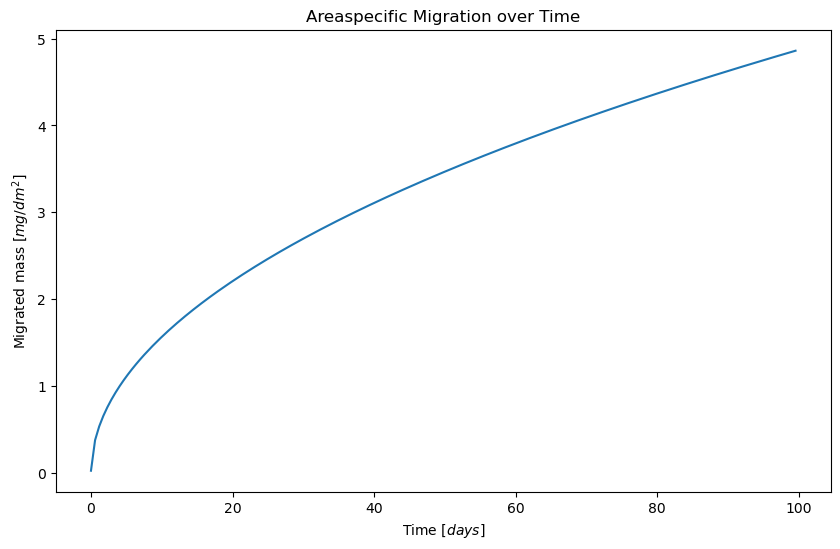

In [11]:
# Plot the migrated mass over time
plot_migrated_mass_over_time(migrated_mass_over_time, time_points)

### Speichern der Ergebnisse

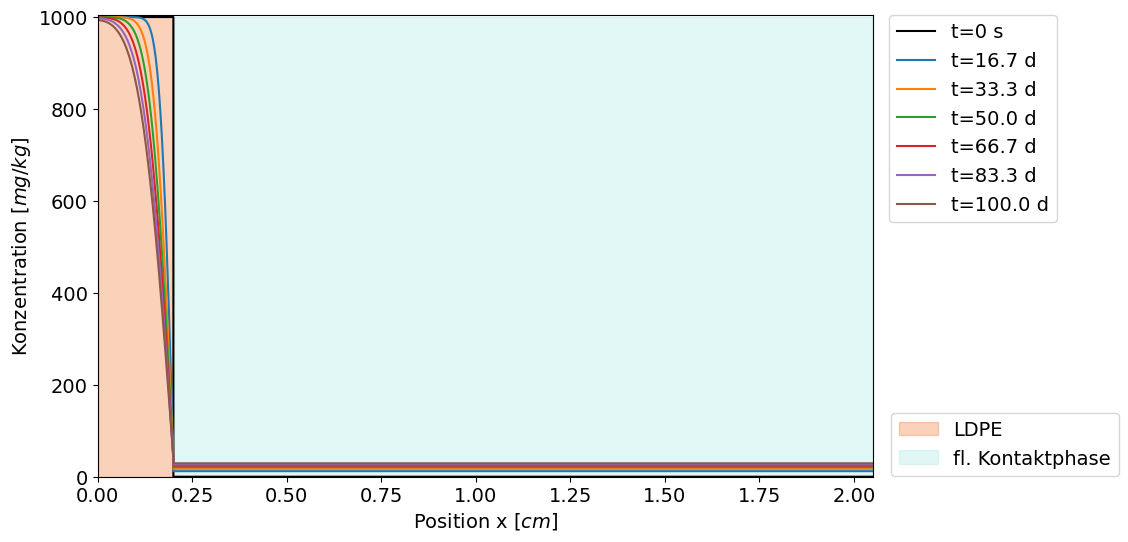

In [28]:
# Plot the results
# Hier noch Log-scale erklären/ plot_intervals
plot_results(C_values, len(C_values), dt, x, C_init, layers, log_scale=False, steps_to_plot=7)

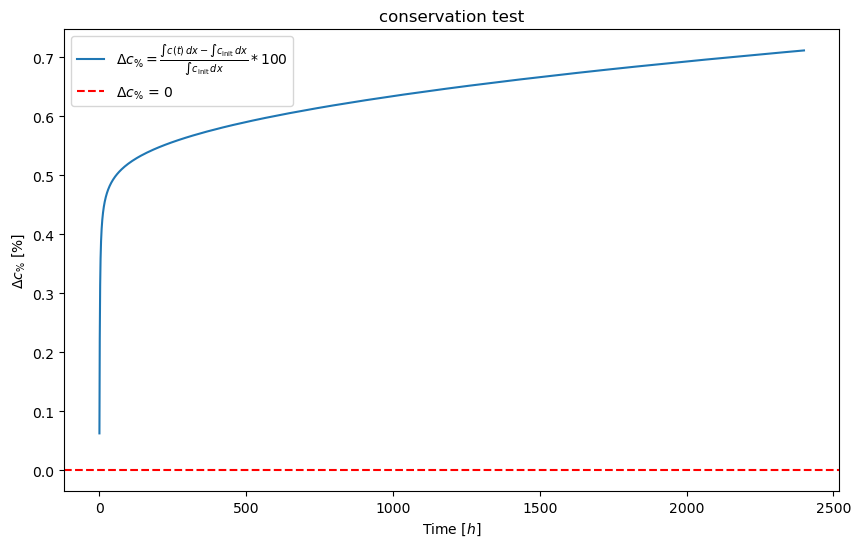

array([0.06280147, 0.11440723, 0.15698526, ..., 0.71170272, 0.71171484,
       0.71172742])

In [13]:
plot_mass_conservation(total_masses, total_masses_init, T, len(total_masses), plot_interval=1)


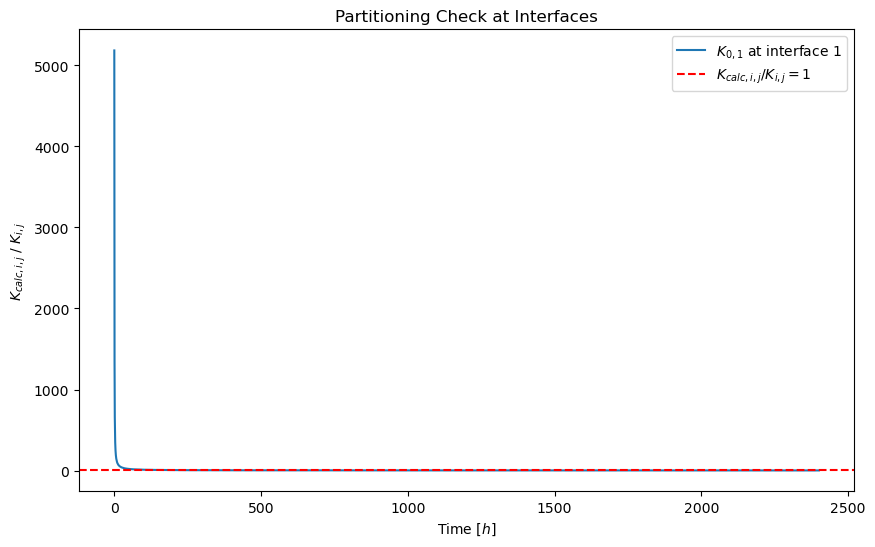

(200.00000000000006, 201.4234548395222)

In [14]:

# Plot the partitioning check
K_values = [layer['K_value'] for layer in layers if layer['K_value'] is not None]
plot_partitioning(partitioning_checks, K_values, dt, len(total_masses))

C_start = np.trapz(C_init, x)
C_end = np.trapz(C_values[-1], x)
C_start, C_end


# Fehlerbetrachtung 

## Einfluss dx

In [15]:
def run_simulation_with_varied_nx(layers, T, dt, nx_values, total_masses_init, steps_to_plot=10):
    # Store the results for different nx values
    mass_conservation_errors = []
    dx_values = []  # To store dx for each nx value

    # Loop over different nx values
    for nx_value in nx_values:
        # Update nx for all layers (assuming equal spacing in each layer)
        for layer in layers:
            layer['nx'] = nx_value

        # Calculate dx for the first layer (you could calculate for each layer if needed)
        dx = layers[0]['d'] / (layers[0]['nx'] - 1)
        dx_values.append(dx)

        # Run the simulation
        C_values, total_masses, x, _ = run_simulation(layers, T, dt, steps_to_plot)

        # Calculate the mass conservation error
        mass_conservation_error = ((np.array(total_masses) - total_masses_init) / total_masses_init) * 100

        # Store the results
        mass_conservation_errors.append(mass_conservation_error)

    return mass_conservation_errors, dx_values

def plot_mass_conservation_for_varied_nx(mass_conservation_errors, dx_values, T, Nt, plot_interval=1):
    # Create an array of time values corresponding to the simulation steps
    time_values = np.linspace(0, T, Nt) / 3600  # Convert to hours

    # Plot the mass conservation errors for each value of dx
    plt.figure(figsize=(10, 6))

    for i, dx in enumerate(dx_values):
        plt.plot(time_values[::plot_interval], mass_conservation_errors[i][::plot_interval], 
                 label=f'$\\Delta x = {dx:.3e}$')

    # Add the mass conservation formula in LaTeX
    plt.text(0.6, 0.1, r"$\Delta m_{\%} = \frac{m(t) - m_{\mathrm{init}}}{m_{\mathrm{init}}} \times 100$", 
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

    plt.axhline(0, color='r', linestyle='--', label="$\Delta m_{{\%}}$ = 0")
    plt.xlabel("Time $[h]$")
    plt.ylabel("$\Delta m_{{\%}}$ $[\%]$")
    plt.legend()
    plt.title("Mass error over time for different values of $\\Delta x$")
    plt.show()

In [16]:
# # Define a range of nx values for testing (different grid resolutions)
# nx_values = [10, 50, 100, 200] 

# # Run the simulation for different nx values and get the mass conservation errors
# mass_conservation_errors, dx_values = run_simulation_with_varied_nx(layers, T, dt, nx_values, total_masses_init)

In [17]:
# # Plot the mass conservation errors for different values of dx
# Nt = int(T / dt)  # Total number of time steps
# plot_mass_conservation_for_varied_nx(mass_conservation_errors, dx_values, T, Nt, plot_interval=1)

## Einfluss dt

In [18]:
def run_simulation_with_varied_dt(layers, T, dt_values, total_masses_init, steps_to_plot=10):
    # Store the results for different dt values
    mass_conservation_errors = []
    
    # Loop over different dt values
    for dt in dt_values:
        # Run the simulation for the current dt
        C_values, total_masses, x, _ = run_simulation(layers, T, dt, steps_to_plot)

        # Calculate the mass conservation error
        mass_conservation_error = ((np.array(total_masses) - total_masses_init) / total_masses_init) * 100

        # Store the results
        mass_conservation_errors.append(mass_conservation_error)

    return mass_conservation_errors, dt_values

def plot_mass_conservation_for_varied_dt(mass_conservation_errors, dt_values, T, plot_interval=1):
    plt.figure(figsize=(10, 6))

    # Loop over different dt values and plot the corresponding mass conservation error
    for i, dt in enumerate(dt_values):
        # Calculate the number of time steps for the current dt
        Nt = int(T / dt)
        # Generate time values for the current dt
        time_values = np.linspace(0, T, Nt) / 3600  # Convert to hours

        # Plot the mass conservation error for the current dt
        plt.plot(time_values[::plot_interval], mass_conservation_errors[i][::plot_interval], 
                 label=f'$\\Delta t = {dt} \\text{{ s}}$')

    # Add a horizontal line at y=0 for perfect mass conservation
    plt.axhline(0, color='r', linestyle='--', label="$\Delta m_{{\%}}$ = 0")
    
    # Set axis labels with LaTeX formatting
    plt.xlabel(r"Time $[\mathrm{h}]$", fontsize=12)
    plt.ylabel(r"$\Delta m_{{\%}}$ $[\%]$", fontsize=12)
    
    # Add the legend with LaTeX formatted labels
    plt.legend(fontsize=12)
    
    # Set the title with LaTeX formatting, including the mass conservation formula
    plt.title(r"Mass error over time for different values of $\Delta t$", fontsize=14)
    
    # Add the mass conservation formula in LaTeX
    plt.text(0.6, 0.1, r"$\Delta m_{\%} = \frac{m(t) - m_{\mathrm{init}}}{m_{\mathrm{init}}} \times 100$", 
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

    # Display the plot
    plt.show()


In [19]:
# # Define a range of dt values for testing (different time step sizes)
# dt_values = [50, 100, 500, 1000]  # You can customize these

# # Run the simulation for different dt values and get the mass conservation errors
# mass_conservation_errors, dt_values = run_simulation_with_varied_dt(layers, T, dt_values, total_masses_init)


In [20]:
# # Plot the mass conservation errors for different values of dt
# plot_mass_conservation_for_varied_dt(mass_conservation_errors, dt_values, T, plot_interval=1)